# Water Balance Project
1. Display soil moisture data. 
We have 135 soil moisture files. Each file has a time dimension equal to 1, so I presume one per month. Each file has 6 depths for soil moisture readings. And then each file has 4 lat and 6 long locations.

In [51]:
# Import requiried packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import netCDF4 as nc
from netCDF4 import MFDataset
from pathlib import Path
import contextily as cx
import xarray as xr
import dask
import pynhd as nhd
import pandas as pd
import geopandas as gpd
import regionmask as rm
from shapely.geometry import box
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd
import contextily as cx
import folium
import rioxarray

# for plotting
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

## Open all files at once and load them into a single xarray dataset
xr.open_mfdataset() will read all the files indicated by the wildcard. It will even parse the time axis correctly so that the time slices are in the right order.
http://xarray.pydata.org/en/stable/io.html#netcdf

In [28]:
ds = xr.open_mfdataset('/home/jovyan/data/whw2020_waterbalance/data/SoilMoistureData/*.nc4')

Check out the dataset to make sure it is ok


In [29]:
ds

,Array,Chunk
Bytes,6.34 kB,96 B
Shape,"(66, 6, 2)","(1, 6, 2)"
Count,264 Tasks,66 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,171.07 kB,2.59 kB
Shape,"(66, 6, 6, 18)","(1, 6, 6, 18)"
Count,198 Tasks,66 Chunks
Type,float32,numpy.ndarray


## Sum the soil moisture with depth
We store the otuput in a new data array called total_sm and we sum along the depth dimension

In [30]:
ds['total_sm']=ds.SOILM.sum(dim='depth')

Look at this new array

In [31]:
ds['total_sm']

,Array,Chunk
Bytes,28.51 kB,432 B
Shape,"(66, 6, 18)","(1, 6, 18)"
Count,462 Tasks,66 Chunks
Type,float32,numpy.ndarray


(array([ 316.,  680., 1228., 1465., 1105.,  785.,  629.,  547.,  304.,
          69.]),
 array([ 229.3349 ,  388.13187,  546.92883,  705.7258 ,  864.5228 ,
        1023.3198 , 1182.1168 , 1340.9137 , 1499.7107 , 1658.5077 ,
        1817.3047 ], dtype=float32),
 <BarContainer object of 10 artists>)

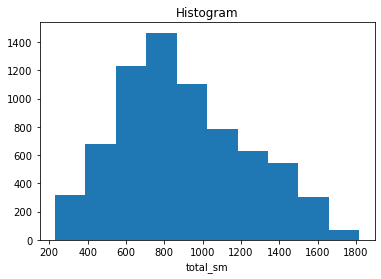

In [32]:
# In this plot statement, we use col='time' to tell xarray that we want an individual plot for each time value
ds.total_sm.plot()

## Plot the Lower Yakima Basin

In [33]:
ly_huc08code = '17030003' 

In [34]:
def wfs_getfeatures_cqlfilter(wd, cql_filter=None):
    """
    Use hydrodata packages to issue and process a OpenGeospatial Consortium (OGC) Web Feature Service (WFS) 
    request for WBD watersheds, with an optional filter to obtain only the watersheds we want.
    Returns a nice and clean GeoPandas GeoDataframe in "lat-lon" projection (epsg:4326)
    """
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
    }
    if type(cql_filter) is str:
        payload["cql_filter"] = cql_filter

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [35]:
ly_wdhuc12 = nhd.WaterData('huc12', crs='epsg:4269')

In [36]:
print(ly_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [37]:
# HUC filter (cql_filter) will be the string "huc12 LIKE '17030001%'"
ly_huc12_gdf = wfs_getfeatures_cqlfilter(
    ly_wdhuc12, 
    cql_filter=f"huc12 LIKE '{ly_huc08code}%'"
)

ly_huc12_gdf.head(2)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-120.00790 46.34360, -120.0105...",170300030903,170300030906,11585.190699,46.883603,City of Sunnyside,S,"AD,GC,CD",WA,0,"[-120.0744, 46.3067, -119.9935, 46.451]"
1,"MULTIPOLYGON (((-119.79200 46.44140, -119.7928...",170300030901,170300030906,14316.612399,57.937275,Sulphur Creek,S,"GC,CD",WA,0,"[-119.9933, 46.3313, -119.792, 46.4558]"


In [38]:
ly_huc12_gdf['huc10'] = ly_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
ly_huc10_gdf = ly_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(ly_huc10_gdf)

12

In [39]:
ly_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1703000301,"POLYGON ((-120.47140 46.53640, -120.47030 46.5...",442.156197
1,1703000302,"POLYGON ((-120.07770 46.59020, -120.07850 46.5...",622.985754


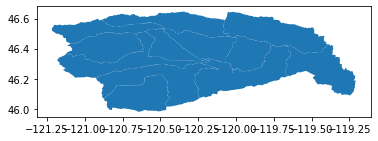

In [40]:
ly_huc10_gdf.plot();

In [41]:
ly_huc10_gdf.total_bounds

array([-121.219 ,   45.9828, -119.2051,   46.6464])

In [42]:
ly_bbox = gpd.GeoSeries(box(*ly_huc10_gdf.total_bounds), crs=ly_huc10_gdf.crs)

In [59]:
ly_lon_slice = slice(ly_bbox.bounds.minx[0], ly_bbox.bounds.maxx[0])
ly_lat_slice = slice(ly_bbox.bounds.miny[0], ly_bbox.bounds.maxy[0])

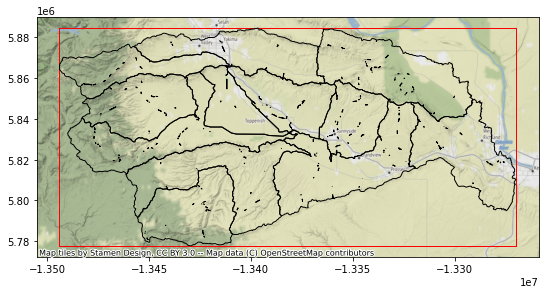

In [60]:
# Project the geopandas datasets to 3857 (web mercator, "Google Maps") 
# so the basemap is not warped and interpolated and will render more quickly
ax = ly_bbox.to_crs(epsg=3857).plot(edgecolor="red", facecolor='none', figsize=(9, 9))
ly_huc10_gdf.to_crs(epsg=3857).plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax)

## Plot the soil moisture data for only our basin (2020)

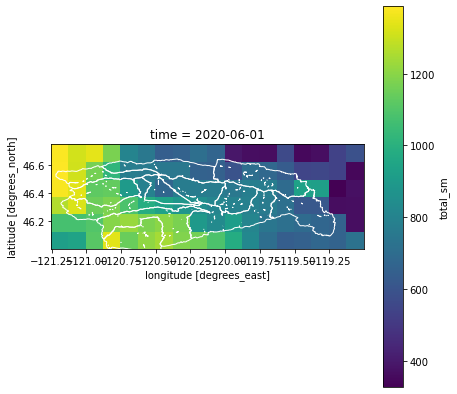

In [61]:
f, ax = plt.subplots(1, figsize=(7,7))
ds.total_sm.isel(time=-1).plot(ax=ax)
ly_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

In [77]:
ly_ds = ds.rio.clip(ly_huc10_gdf.geometry, all_touched=True)

DimensionError: x dimension (lon) not found. Data variable: depth_bnds